In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import sklearn.neighbors
import sklearn.model_selection as mose
from sklearn.metrics import accuracy_score
import sklearn.pipeline
import sklearn.tree
import matplotlib.pyplot as plt
import sklearn.ensemble

In [2]:
dataset = np.loadtxt('agaricus-lepiota.data', delimiter = ',', dtype = 'str')

## Датасет о грибах. Ссылка на датасет: http://archive.ics.uci.edu/ml/datasets/Mushroom
## Описание столбцов взято с сайта.
|cap-shape|cap-surface|cap-color|bruises|odor|gill-attachment|gill-spacing|gill-size|gill-color|stalk-shape|stalk-root|stalk-surface-above-ring|stalk-surface-below-ring|stalk-color-above-ring|stalk-color-below-ring|veil-type|veil-color|ring-number|ring-type|spore-print-color|population|habitat|class|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s|fibrous=f,grooves=g,scaly=y,smooth=s|brown=n, buff=b, cinnamon=c, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y|bruises=t,no=f|almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m, none=n, pungent=p, spicy=s|attached=a,descending=d,free=f,notched=n| close=c,crowded=w,distant=d|broad=b,narrow=n|black=k, brown=n, buff=b, chocolate=h, gray=g, green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y|enlarging=e, tapering=t|bulbous=b, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r, missing=?|fibrous=f,scaly=y,silky=k,smooth=s|fibrous=f, scaly=y, silky=k, smooth=s|brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y|brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w,yellow=y|partial=p,universal=u|brown=n,orange=o,white=w,yellow=y|none=n,one=o,two=t|cobwebby=c, evanescent=e, flaring=f, large=l, none=n, pendant=p, sheathing=s, zone=z| black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y|abundant=a, clustered=c, numerous=n, scattered=s, several=v, solitary=y|grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d|edible, poisonous|

## Для вашего датасета преобразовать категориальные признаки в бинарные с помощью pd.factorize / pd.get_dummies

In [3]:
data = pd.DataFrame(dataset)
y = data[0]
data = pd.get_dummies(data, drop_first = True)
X_train, X_test, y_train, y_test = mose.train_test_split( data.values, y, test_size=0.3)

## С помощью sklearn.preprocessing.StandardScaler нормализовать значения признаков и построить для нормализовапнного датасета KNeighborsClassifier (без использования конвееров)
### Построим классификатор KNN с 10 соседями. Точность классификации почти 100 % на тестовых данных.

In [4]:
scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(data)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = mose.train_test_split( scaled_data, y, test_size=0.3)

In [5]:
classifier = sklearn.neighbors.KNeighborsClassifier( n_neighbors = 10 )
classifier.fit(X_train_scaled, y_train_scaled)
p = classifier.predict(X_test_scaled)
accuracy_score(y_test_scaled, p)

0.9983593109105825

## То же самое и использованием sklearn.pipeline.Pipeline
### Сделаем pipeline с нормализацией и классификатором KNN. Точность почти равна 1 на тестовых данных.

In [6]:
classifier_pipe = sklearn.pipeline.Pipeline([
    ('scaler', sklearn.preprocessing.StandardScaler()),
    ('knn', sklearn.neighbors.KNeighborsClassifier(n_jobs=-1))
])

In [7]:
classifier_pipe.fit(X_train, y_train)
p = classifier_pipe.predict(X_test)
accuracy_score(y_test, p)

0.9995898277276456

## С помощью GridSearchCV произвести подбор гиперпараметра KNeighborsClassifier (n_neighbors) и выведите значение гиперпараметра и метрику для наилучшей модели
### Подберем лучшее количество соседей от 1 до 10. Лучшее количество соседей равно 1, а точность почти 1.

In [8]:
classifier_params = { 'knn__n_neighbors': range(1, 10) }

classifier_grid = sklearn.model_selection.GridSearchCV(
    classifier_pipe, classifier_params, cv = 5, n_jobs = -1, verbose = True
)

classifier_grid.fit( X_train_scaled, y_train_scaled )

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   26.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=-1,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             

In [10]:
classifier_grid.best_params_, classifier_grid.best_score_

({'knn__n_neighbors': 1}, 0.9998240985048372)

## Продемонстрировать работу DecisionTreeClassifier, посчитать метрики качества на отложенной выборке
### Построим дерево решений с максимальной глибиной 5. Точность почти равна 1

In [11]:
classifier_tree = sklearn.tree.DecisionTreeClassifier( max_depth = 5, random_state = 17 )
classifier_tree.fit(X_train_scaled, y_train_scaled)
p = classifier_tree.predict(X_test_scaled)
accuracy_score(y_test_scaled, p)

1.0

## С помощью GridSearchCV произвести подбор гиперпараметров для поиск наилучшего дерева (перебрать max_depth, max_features и может быть что-то ещё)
### Найдем лучшие максимальную глубину и максимальное количество признаков. Лучшая глубина дерева равна 8. Лучшее количество признаков равно 5. Точность равна 1.

In [12]:
classifier_tree_params = { 'max_depth': range(1, 10), 'max_features': range(1, 10) }

classifier_tree_grid = sklearn.model_selection.GridSearchCV(
    classifier_tree, classifier_tree_params, cv = 5, n_jobs = -1, verbose = True
)

classifier_tree_grid.fit( X_train, y_train )

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:    1.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=17,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
                         'max_fea

In [13]:
classifier_tree_grid.best_params_, classifier_tree_grid.best_score_

({'max_depth': 8, 'max_features': 5}, 1.0)

## Для полученного наилучшего дерева построить график feature_importances и дополнительно напечатать 3 наиболее важных признака, отсортиров их по убыванию по важности
### Название признаков не получается разобрать, потому что признаки стали числовыми, и их стало больше. В итоге каждый признак стал содержать несколько новых.

In [14]:
classifier_tree_best_params = sklearn.tree.DecisionTreeClassifier( max_depth = 8, max_features = 5 )
classifier_tree_best_params.fit(X_train_scaled, y_train_scaled)
p = classifier_tree_best_params.predict(X_test_scaled)

In [15]:
def plot_feature_importances_mushrooms(model, n_features):
    plt.figure(figsize=(10, 25))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.columns)
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")

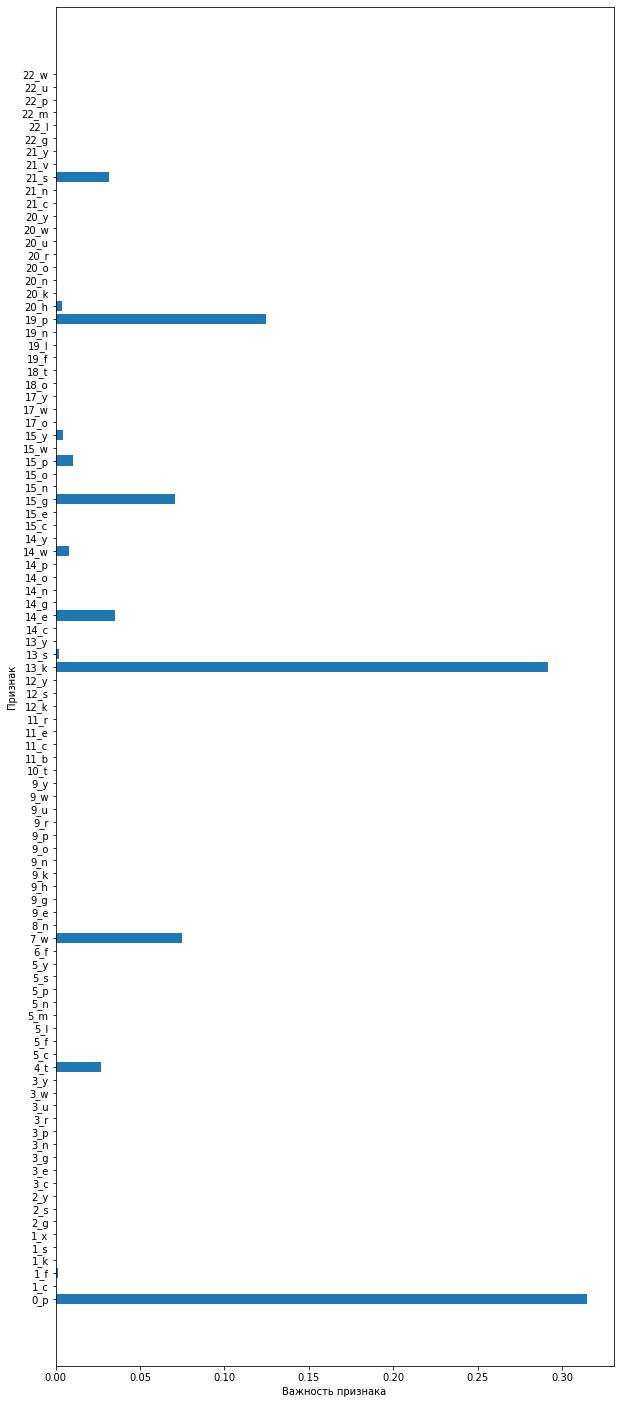

In [16]:
plot_feature_importances_mushrooms(classifier_tree_best_params, len(data.columns))

In [17]:
params = []
for name, score in zip(data.columns, classifier_tree_best_params.feature_importances_):
    params.append([name, score])
params.sort(key = lambda v: v[1], reverse = True)
print(params[0: 3])

[['0_p', 0.31471819200251433], ['13_k', 0.2915961119819243], ['19_p', 0.12463803936486748]]


## Продемонстрировать работу случайного леса RandomForestClassifier
### Построим случайный лес с 100 деревьями. Точность при всех 5 запусках равна почти 1.

In [18]:
forest = sklearn.ensemble.RandomForestClassifier( n_estimators=100, n_jobs=-1, random_state=17 )

sklearn.model_selection.cross_val_score(forest, X_train_scaled, y_train_scaled, cv=5)

array([1., 1., 1., 1., 1.])

## С помощью GridSearchCV произвести подбор гиперпараметров для поиск наилучшего леса, посмотреть насколько улучшились метрики
### Будем искать максимальную глубину и максимальное количество признаков. Лучшая глубина равна 5. Лучшее количество признаков равно 8. Точность равна 1.

In [19]:
forest_params = {
    'max_depth': range(1,10),
    'max_features': range(1,10)
}

forest_grid = sklearn.model_selection.GridSearchCV(
    forest, forest_params, cv = 5, n_jobs = -1, verbose = True
)

forest_grid.fit(X_train_scaled, y_train_scaled)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  1.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=17,
                                    

In [20]:
forest_grid.best_params_, forest_grid.best_score_

({'max_depth': 5, 'max_features': 8}, 1.0)

# Лучшие классифкаторы те, которые основаны на деревьях решений. Такие классифкаторы имеют точность 1.